Train model and generate trained models performace summary.  
Models are ordered by validation performace from good to bad

In [2]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from vol_predict import VolPredictor
from sklearn.model_selection import train_test_split

ticker = 'GLD'
DAYS_WINDOW_SIZE = 21
RETRIEVE_PERIOD = '5y'
SEQUENCE_LENGTH_WINDOWS = 6
TARGET_STEPS = 1

model_path = f'./vol_output/vol_lstm_{datetime.today().date()}.keras'
scaler_path = './vol_output/scaler.pkl'

predictor = VolPredictor()

market_data = predictor.get_market_data(ticker, retrieve_period=RETRIEVE_PERIOD)

if len(market_data) == 0:
    print('WARNING: There is no market data retrieved')
    
vol_data = predictor.calculate_return(market_data)

col_name = f'{predictor._VCOL_PREFIX}_{DAYS_WINDOW_SIZE}'
vol_data[col_name] = vol_data['Log_Returns'].rolling(window=DAYS_WINDOW_SIZE).std() * np.sqrt(252) # annulise daily volatility
vol_data['Avg_Volume_21D'] = vol_data['Volume'].rolling(window=21).mean()
vol_data['Avg_Volume_10D'] = vol_data['Volume'].rolling(window=10).mean()
vol_data['Avg_Volume_5D'] = vol_data['Volume'].rolling(window=5).mean()
vol_data = vol_data.iloc[DAYS_WINDOW_SIZE:]

col_names = list(vol_data.columns[-4:])
scaled_vol_data = predictor.normalise_data(vol_data, cols=col_names)

feature_cols = ['Date'] + [col for col in scaled_vol_data.columns if col.startswith(predictor._FEATURE_PREFIX)]
feature_data_array = scaled_vol_data[feature_cols].values
X_all_date, y_all_date = predictor.restruncture_data(feature_data_array, vol_window_days=DAYS_WINDOW_SIZE, sequence_months=SEQUENCE_LENGTH_WINDOWS, target_steps=TARGET_STEPS)

# Remove features after volatility. Only leave Date and Scaled Vol
y_all_date = y_all_date[:, :2]

X_train_val_date, X_test_date, y_train_val_date, y_test_date = train_test_split(X_all_date, y_all_date, test_size=0.2, random_state=42) 

# Features: Date - removing from data. 
X_train_val = X_train_val_date[:,:,1:].astype(np.float64).reshape(-1, SEQUENCE_LENGTH_WINDOWS, len(col_names))
y_train_val = y_train_val_date[:, 1].astype(np.float64).reshape(-1, 1)

tuner = predictor.train_model(X_train_val, y_train_val, model_path=model_path)



joblib.dump(predictor.scaler, scaler_path)



Trial 20 Complete [00h 01m 52s]
multi_objective: 0.0036054381635040045

Best multi_objective So Far: 0.002340880688279867
Total elapsed time: 00h 43m 35s


['./vol_output/scaler.pkl']

In [3]:
import pandas as pd

model = predictor.load_model(model_path)
scaler = joblib.load(scaler_path)

y_cols = ['Date', 'Scaled_Target']

X_array = X_all_date[:, :, 1:].astype(np.float64).reshape(-1, SEQUENCE_LENGTH_WINDOWS, len(col_names))
y_array = y_all_date[:,1].astype(np.float64).reshape(-1, 1)

X_test = X_test_date[:,:,1:].astype(np.float64).reshape(-1, SEQUENCE_LENGTH_WINDOWS, len(col_names))
y_test = y_test_date[:, 1].astype(np.float64).reshape(-1, 1)

y_pred_all = model.predict(X_array)
y_pred_all_df = pd.DataFrame(columns=y_cols, data=y_all_date)
y_pred_all_df['Scaled_Predicted'] = y_pred_all
# y_pred_all_df['Predicted'] = scaler.inverse_transform(y_pred_all)
# Suppose the first feature is scaled RV
feature_index = 0
y_pred_all_df['Predicted'] = (y_pred_all - scaler.min_[feature_index])/ scaler.scale_[feature_index]
 
y_merged_all_df = pd.merge(left=vol_data[['Date', 'Rv_21']], right=y_pred_all_df, on='Date')

X_test = X_test_date[:,:,1:].astype(np.float64).reshape(-1, SEQUENCE_LENGTH_WINDOWS, len(col_names))
y_test = y_test_date[:, 1].astype(np.float64).reshape(-1, 1)

y_pred_test = model.predict(X_test)
y_pred_test_df = pd.DataFrame(columns=y_cols, data=y_test_date)
y_pred_test_df['Scaled_Predcited'] = y_pred_test
# y_pred_test_df['Predicted'] = scaler.inverse_transform(y_pred_test)

# Suppose the first feature is scaled RV
y_pred_test_df['Predicted'] = (y_pred_test - scaler.min_[feature_index]) / scaler.scale_[feature_index] 

y_merged_test_df = pd.merge(left=vol_data, right=y_pred_test_df, on='Date')

7/7 [==============================] - 0s 33ms/step


In [4]:
y_merged_all_df.to_excel(f'./vol_output/GLD_Pred21D_11Jun.xlsx')

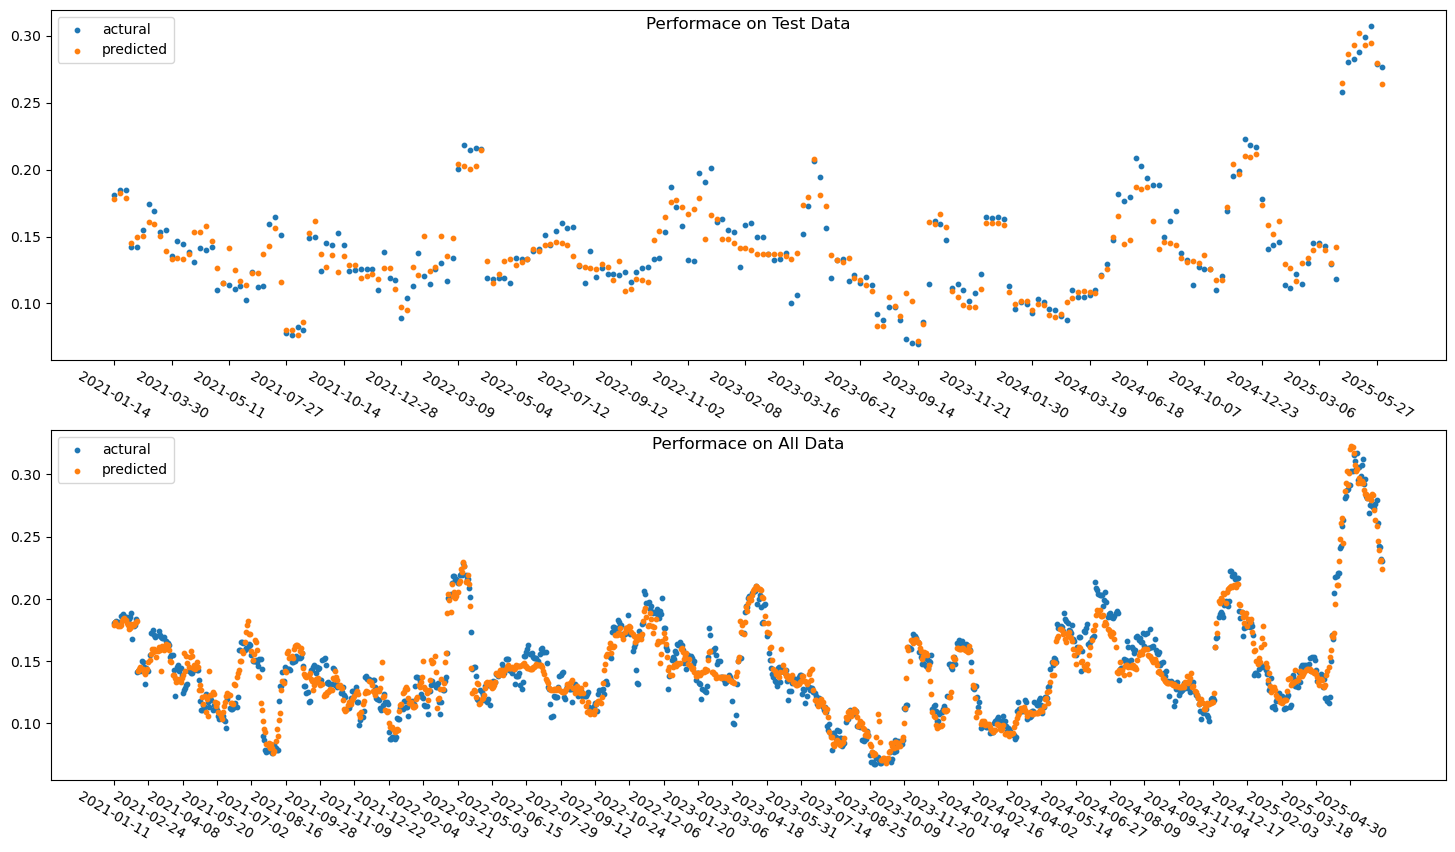

In [5]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(18, 10))
# Test Data
axs[0].scatter(y=y_merged_test_df['Rv_21'], x=y_merged_test_df.index, label='actural', s=10)
axs[0].scatter(y=y_merged_test_df['Predicted'], x=y_merged_test_df.index, label='predicted', s=10)
axs[0].set_title('Performace on Test Data', y=1, pad=-14)
axs[0].legend()

ind = list(range(0, len(y_merged_test_df), 10))

axs[0].set_xticks(ind)
axs[0].set_xticklabels(y_merged_test_df['Date'].iloc[ind], rotation=-30)


# All Data
axs[1].scatter(y=y_merged_all_df['Rv_21'], x=y_merged_all_df.index, label='actural', s=10)
axs[1].scatter(y=y_merged_all_df['Predicted'], x=y_merged_all_df.index, label='predicted', s=10)
axs[1].set_title('Performace on All Data', y=1, pad=-14)
axs[1].legend()

ind_all = list(range(0, len(y_merged_all_df), 30))

axs[1].set_xticks(ind_all)
axs[1].set_xticklabels(y_merged_all_df['Date'].iloc[ind_all], rotation=-30)


plt.show()

Plot models performance

35/35 [==============================] - 1s 14ms/step - loss: 0.0259 - smape: 41.2790


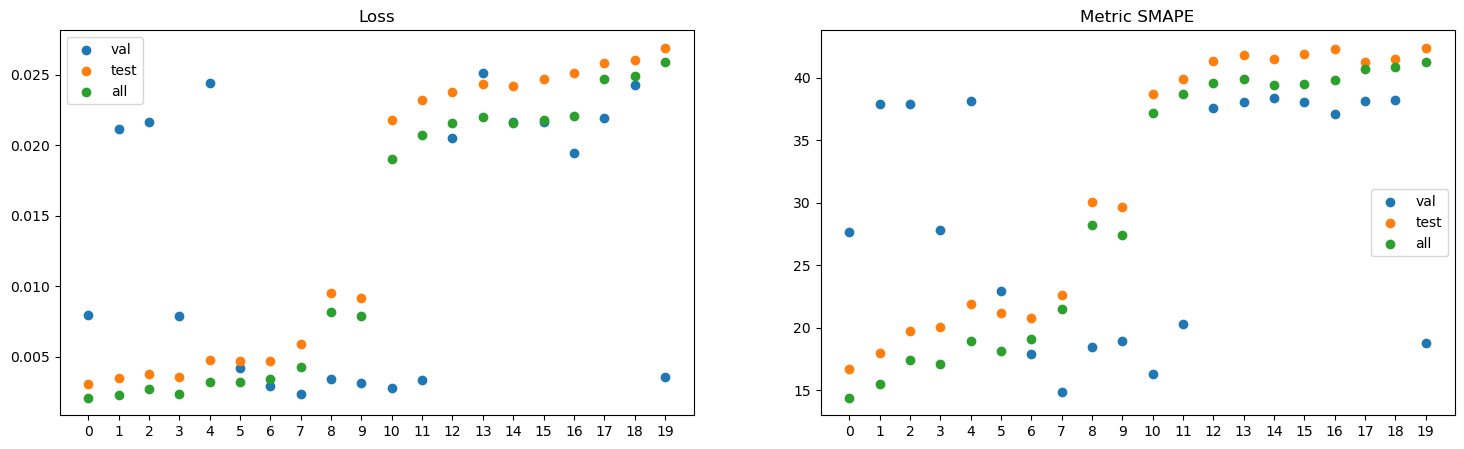

In [6]:
# Different trainded model performance

trial_performance_df = predictor.generate_model_performance(tuner, X_test=X_test, y_test=y_test, X_all=X_array, y_all=y_array)
trial_performance_df

fig, axs = plt.subplots(1, 2, figsize=(18, 5))

axs[0].scatter(y=trial_performance_df['score'], x=trial_performance_df.index, label='val')
axs[0].scatter(y=trial_performance_df['test_loss'], x=trial_performance_df.index, label='test')
axs[0].scatter(y=trial_performance_df['all_loss'], x=trial_performance_df.index, label='all')
axs[0].set_title('Loss')
axs[0].set_xticks(trial_performance_df.index)
axs[0].legend()

axs[1].scatter(y=trial_performance_df['val_smape_last'], x=trial_performance_df.index, label='val')
axs[1].scatter(y=trial_performance_df['test_metric'], x=trial_performance_df.index, label='test')
axs[1].scatter(y=trial_performance_df['all_metric'], x=trial_performance_df.index, label='all')
axs[1].set_title('Metric SMAPE')
axs[1].set_xticks(trial_performance_df.index)
axs[1].legend()

plt.show()

In [ ]:
trial_performance_df.to_excel(f'./vol_output/trial_performance_{datetime.today().date()}.xlsx')

Predict on lastest data

In [ ]:
from vol_predict import VolPredictor

DAYS_WINDOW_SIZE = 21
SEQUENCE_LENGTH_WINDOWS = 6
ticker = 'GLD'
saved_scaler = joblib.load(scaler_path)

vol_predictor = VolPredictor()
num_samples = DAYS_WINDOW_SIZE * (SEQUENCE_LENGTH_WINDOWS-1) + 1
pred_market_data = vol_predictor.get_market_data(ticker=ticker, retrieve_period=f'{SEQUENCE_LENGTH_WINDOWS + 2}mo')

if len(pred_market_data) == 0:
    print('WARNING: No market data has been retrieved /n/n')

pred_return_vol = vol_predictor.calculate_return(data_df=pred_market_data)

col_name = f'{predictor._VCOL_PREFIX}_{DAYS_WINDOW_SIZE}'
pred_return_vol[col_name] = pred_return_vol['Log_Returns'].rolling(window=DAYS_WINDOW_SIZE).std() * np.sqrt(252) # annulise daily volatility
pred_return_vol['Avg_Volume_21D'] = pred_return_vol['Volume'].rolling(window=21).mean()
pred_return_vol['Avg_Volume_10D'] = pred_return_vol['Volume'].rolling(window=10).mean()
pred_return_vol['Avg_Volume_5D'] = pred_return_vol['Volume'].rolling(window=5).mean()
pred_return_vol = pred_return_vol.iloc[DAYS_WINDOW_SIZE:]

col_names = list(pred_return_vol.columns[-4:])
pred_scaled_vol_data = predictor.normalise_data(pred_return_vol, cols=col_names, scaler=saved_scaler)


feature_cols = [col for col in pred_scaled_vol_data.columns if col.startswith(vol_predictor._FEATURE_PREFIX)]
pred_feature_data_array = pred_scaled_vol_data[feature_cols].values
X_pred = vol_predictor.restruncture_data(pred_feature_data_array, vol_window_days=DAYS_WINDOW_SIZE, sequence_months=SEQUENCE_LENGTH_WINDOWS)[-1]

# model = tuner.get_best_models(1)[0]
pred_model = vol_predictor.load_model(model_path)
rv_pred = pred_model.predict(X_pred.reshape(1,SEQUENCE_LENGTH_WINDOWS,len(col_names)))

rv_inver_pred = (rv_pred - saved_scaler.min_[0]) / saved_scaler.scale_[0]
print(X_pred)
print(rv_pred)
print(rv_inver_pred)

[[0.31652432 0.06473657 0.03157651 0.08459127]
 [0.21717782 0.23707388 0.296431   0.29949249]
 [0.29887269 0.22706698 0.22668916 0.1910023 ]
 [0.6012109  0.479924   0.64943111 0.65616057]
 [0.95471456 0.56028388 0.30705192 0.29073196]
 [0.55409426 0.3414327  0.23446585 0.16148504]]
[[0.34015352]]
[[0.15213352]]


Get corresponding Implied Vol

In [14]:
from pandas.tseries.offsets import BDay
import iv_helper 

from importlib import reload

reload(iv_helper)

ticker = 'GLD'
# The end point for the sequent data used to predict next time step realised vol
current_date = pred_market_data.iloc[-1]['Date']
target_date = (current_date + BDay(DAYS_WINDOW_SIZE)).date()

asset = iv_helper.get_asset(ticker)
market_price = iv_helper.get_asset_price_for_given_date(asset, current_date)
iv = iv_helper.get_implied_vol(asset, market_price, target_date)

In [15]:
print(f'Implied Vol: {iv:.4f}, Realised Vol: {rv_inver_pred[0][0]:.4f}')

Implied Vol: 0.1785, Realised Vol: 0.1521


Strategy 

if iv - rv > threshold:
    sell straddle -- to earn premium
                     expecting market overestimate volatililty
                     the asset price stays small movement and both options expire worthless
                     if asset price move a lot, the losses can be large. price increase can be unlimited

if iv - rv < -threshold:
    buy straddle --  to earn one leg of the straddle profit
                     expecting market is underestimating volatility 
                     the asset price will move a lot and one leg of straddle profit
                     if asset price stays flat, the lossees will be premiums of both options
                            